# A Review of [WILDS: A Benchmark of in-the-Wild Distribution Shifts](https://arxiv.org/pdf/2012.07421.pdf)

In [ ]:
! pip install wilds

     |████████████████████████████████| 92 kB 316 kB/s 
     |████████████████████████████████| 78 kB 2.2 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=87498b4fcccb3940a2c577ff359dfdfd09011fc10422496a4cb70e2ff3a59ab0
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
from wilds.common.data_loaders import get_eval_loader

import torchvision.transforms as transforms

In [ ]:
# %load_ext autoreload
# %autoreload 2

# from wilds import get_dataset
# from wilds.common.data_loaders import get_train_loader
# import torchvision.transforms as transforms

# # Load the full dataset, and download it if necessary
# dataset = get_dataset(dataset='iwildcam', download=True)

# # Get the training set
# train_data = dataset.get_subset('train',
#                                 transform=transforms.Compose([transforms.Resize((448,448)),
#                                                               transforms.ToTensor()]))

# # Prepare the standard data loader
# train_loader = get_train_loader('standard', train_data, batch_size=16)

In [ ]:
# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset='civilcomments', download=False)

# Get the training set
# train_data = dataset.get_subset('train',
#                                 transform=transforms.Compose([transforms.Resize((448,448)),
#                                                               transforms.ToTensor()]))
train_data = dataset.get_subset('train')

# Prepare the standard data loader
train_loader = get_train_loader('standard', train_data, batch_size=16)

Implement ERM algorithm on the benchmark, trying to see whether it is robust to distribution shifts:

In [ ]:
import src

src.run_experiment({
    'dataset': 'civilcomments',
    'full_dataset': dataset,
    'algorithm': 'ERM',
    'root_dir': 'data',
    'progress_bar': True,
    'frac': 0.001,
    'n_epochs': 1
})

ModuleNotFoundError: No module named 'wilds.examples'

**implementation in progress: more advanced algorithms such as CORAL/IRM/Group DRO; see if they're better than ERM wrt Out of Distribution performance**

## A toy example of distribution shift

[]

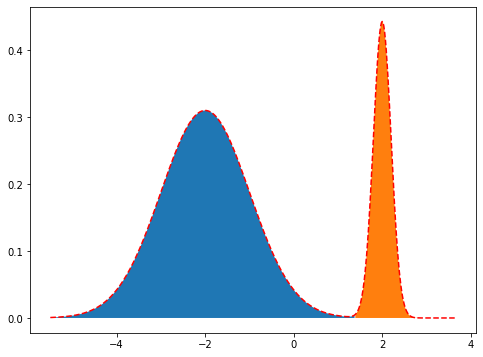

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

loc1, scale1, size1 = (-2, 1, 175)
loc2, scale2, size2 = (2, 0.2, 50)

x2 = np.concatenate([np.random.normal(loc=loc1, scale=scale1, size=size1),
                     np.random.normal(loc=loc2, scale=scale2, size=size2)])
x_eval = np.linspace(x2.min() - 1, x2.max() + 1, 500)
X_train = x_eval[:375]
X_test = x_eval[375:]

bimodal_pdf = (norm.pdf(x_eval, loc=loc1, scale=scale1) * float(size1) / x2.size
               + norm.pdf(x_eval, loc=loc2, scale=scale2) * float(size2) / x2.size)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_eval, bimodal_pdf, 'r--', label="Actual PDF")
ax.fill_between(X_train, bimodal_pdf[:375])
ax.fill_between(X_test, bimodal_pdf[375:])

ax.plot()


In [ ]:
src.run_experiment({
    'dataset': 'iwildcam',
    'full_dataset': bimodal_pdf,
    'algorithm': 'ERM',
    'root_dir': 'data',
    'progress_bar': True,
    'frac': 0.001,
    'n_epochs': 1
})

Dataset: iwildcam
Full dataset: [6.84097403e-04 7.29381034e-04 7.77399730e-04 8.28300072e-04
 8.82235252e-04 9.39365292e-04 9.99857265e-04 1.06388552e-03
 1.13163191e-03 1.20328600e-03 1.27904534e-03 1.35911563e-03
 1.44371102e-03 1.53305427e-03 1.62737704e-03 1.72692004e-03
 1.83193336e-03 1.94267660e-03 2.05941911e-03 2.18244026e-03
 2.31202957e-03 2.44848697e-03 2.59212300e-03 2.74325898e-03
 2.90222719e-03 3.06937109e-03 3.24504546e-03 3.42961655e-03
 3.62346225e-03 3.82697223e-03 4.04054804e-03 4.26460325e-03
 4.49956352e-03 4.74586669e-03 5.00396285e-03 5.27431439e-03
 5.55739601e-03 5.85369473e-03 6.16370990e-03 6.48795315e-03
 6.82694830e-03 7.18123134e-03 7.55135027e-03 7.93786499e-03
 8.34134713e-03 8.76237985e-03 9.20155766e-03 9.65948611e-03
 1.01367815e-02 1.06340708e-02 1.11519907e-02 1.16911881e-02
 1.22523189e-02 1.28360479e-02 1.34430483e-02 1.40740013e-02
 1.47295950e-02 1.54105245e-02 1.61174908e-02 1.68512001e-02
 1.76123632e-02 1.84016949e-02 1.92199128e-02 2.00677

AttributeError: 'numpy.ndarray' object has no attribute 'original_resolution'

In [ ]:
from algorithms.ERM import ERM

class Config:
    dataset
    algorithm
    root_dir
    # Dataset
    split_scheme
    dataset_kwargs={}
    download=False
    frac=1.0,
    version=None
    # Loaders
    loader_kwargs={}
    train_loader
    uniform_over_groups
    distinct_groups
    n_groups_per_batch
    batch_size
    eval_loader='standard'
    # Model
    model='logistic_regression'
    model_kwargs={}
    # Transforms
    transform
    target_resolution
    resize_scale
    max_token_length
    # Objective
    loss_function
    loss_kwargs={}
    # Algorithm
    groupby_fields
    group_dro_step_size
    coral_penalty_weight
    irm_lambda
    irm_penalty_anneal_iters
    algo_log_metric
    # Model selection
    val_metric
    val_metric_decreasing
    # Optimization
    n_epochs
    optimizer
    lr
    weight_decay
    max_grad_norm
    optimizer_kwargs={}
    # Scheduler
    scheduler
    scheduler_kwargs={}
    scheduler_metric_split='val'
    scheduler_metric_name
    # Evaluation
    process_outputs_function
    evaluate_all_splits=True
    eval_splits=[]
    eval_only=False
    eval_epoch=None
    # Misc
    device=0
    seed=0
    log_dir='./logs'
    log_every=50
    save_step
    save_best=True
    save_last=True
    save_pred=True
    no_group_logging
    use_wandb=False
    progress_bar=False
    resume=False

config = populate_defaults(Config())

ERM(config=config,
    d_out=d_out,
    grouper=train_grouper,
    loss=loss,
    metric=metric,
    n_train_steps=n_train_steps)

### November 23, 2021 Questions For Professor

* Jang's traveling, and it's going on 3am for Alex (Singapore)
* Plumbing work so far:
    * Make the library compatible with deepnote
    * Datasets are too large for deepnote
    * Convert command line interface to a callable method
    * Make the library installable on m1 mac
    * Need to run training on GPUs for many hours. Colab Pro? Any AWS credits?

* Struggles:
    * Ran CLI on 1% of a given dataset, and it took 20 minutes per epoch. So results were not that useful.
    * How might I simulate distribution shifts in images?
        * MNIST: train on particular digits
        * why these datasets? Why not MNIST? DSprites
        * HW7. Use scatterplot. If great there, why not images?

Current plan:
    * Should I be trying to do things exactly how the authors did, with their own code? Or should I write my own version of it?
    * NN model architectures (DenseNet-121, ResNet, etc.). Can I use my own architecture?
    * Is it sound to simply compare logistic regression with different loss measures?

Failure case:

* https://openreview.net/pdf?id=ryxGuJrFvS

> upweighting fails on MultiNLI, achieving lower average and worst-group accuracies than even ERM. With upweighting, it appears that the rare group is overemphasized and extremely low training accuracy is achieved for that group at the cost of others

# The framework for final deliverables

## Problem statement
> What is the problem the paper aims to solve?

## Context/scope
> Why is this problem important or interesting?

## Existing work
> What has been done in literature?

## Contribution
> What is gap in literature that the paper is trying to fill? What is the unique contribution?

## Technical content (high level)

> What are the high level ideas behind their technical contribution?

### Distribution shifts

Where training distribution differs from the test distribution

#### Domain Generalization

Training and test distributions comprise data from related but distinct domains

#### Subpopulation Shift

Test distributions that are subpopulations of the training distribution

### 

## Technical content (details)
> Highlight (not copy and paste entire sections) the relevant details that are important to focus on (e.g. if there's a model, define it; if there is a theorem, state it and explain why it's important, etc).

## Experiments
> Which types of experiments were performed? What claims were these experiments trying to prove? Did the results prove the claims?

## Evaluation (your opinion)
> Do you think the work is technically sound? Do you think the proposed model/inference method is practical to use on real data and tasks? Do you think the experimental section was strong (there are sufficient evidence to support the claims and eliminate confounding factors)?

## Future work (for those interested in continuing research in a related field)
> Do you think you can suggest a concrete change or modification that would improve the existing solution(s) to the problem of interest? Try to implement some of these changes/modifications.

## Broader Impact
> How does this work potentially impact (both positively and negatively) the broader machine learning community and society at large when this technology is deployed? In the applications of this technology, who are the potentially human stakeholders? What are the potential risks to the interest of these stakeholders in the failure modes of this technology? Is there potential to exploit this technology for malicious purposes?

## Code
* At least one clear working pedagogical example demonstrating the problem the paper is claiming to solve. 
* At lease a bare bones implementation of the model/algorithm/solution (in some cases, you may be able to make assumptions  to simplify the model/algorithm/solution with the approval of your instructor)
* Demonstration on at least one instance that your implementation solves the problem.
* Demonstration on at least one instance the failure mode of the model/algorithm/solution, with an explanation for why failure occurred (is the dataset too large? Did you choose a bad hyper parameter?). The point of this is to point out edge cases to the user.

**NOTE**: Look at https://github.com/onefishy/am207_fall19_projects/blob/master/calibrated_uncertainty/calibrated_uncertainty_2/report.ipynb for inspiration regarding how they weaved code into the above sections.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=80cb1556-c762-4c6a-89b8-6410c844af03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>